# WeatherPy
---

In [1]:
# Dependencies and Setup
import time
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from scipy.stats import linregress
# citipy is not part of PythonData default packages, use `pip install citipy`
from citipy import citipy

from api_keys import weather_api_key

## Generate Random Geographic Coordinates and a List of Cities

### Generate the Cities List by Using the `citipy` Library

In [10]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 631


---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the started code

In [11]:
# Prevent re-running this cell after output has been saved to CSV.
weather_csv_file_path = Path("output_data/cities.csv")
if weather_csv_file_path.exists():
    error_message = f""" DO NOT RUN
    Preventing cell from running due to exported CSV file already existing.
        File at: '{weather_csv_file_path.absolute()}'
    Use `pd.read_csv("output_data/cities.csv")` instead to get weather data.
    Running this cell again will take more than *{len(cities) // 60} minutes* with a free OpenWeather API key."""
    raise Exception(error_message)



# Set the API base URL
base_url = "https://api.openweathermap.org/data/2.5/weather?"

# Define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):

    # Group in batches of 59 since free OpenWeather API limit is 60 calls per minute
    if (i % 59 == 0 and i >= 59):
        print("Waiting for API rate limit to reset (60 seconds)")
        time.sleep(60)
        
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    city_url = f"{base_url}q={city}&units=metric&appid={weather_api_key}"
    
    # Log the url, record, and set numbers
    print(f"Processing Record {record_count} of Set {set_count} | {i} | {city}")

    # Add 1 to the record count
    record_count += 1

    # Run an API request for each of the cities
    try:
        weather_response = requests.get(city_url)

        # if status code is not 200, the request failed
        if weather_response.status_code != 200:
            print(f"  City not found. Skipping... {city}")
            continue

        # Parse the JSON and retrieve data
        c_w_json = weather_response.json()

        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": c_w_json["coord"]["lat"], 
                          "Lng": c_w_json["coord"]["lon"], 
                          "Max Temp": c_w_json["main"]["temp_max"],
                          "Humidity": c_w_json["main"]["humidity"],
                          "Cloudiness": c_w_json["clouds"]["all"],
                          "Wind Speed": c_w_json["wind"]["speed"],
                          "Country": c_w_json["sys"]["country"],
                          "Date": c_w_json["dt"]})
    # If an error is experienced, skip the city
    except Exception as e:
        print(f"  City not found. Skipping... {city}", e)

print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | 0 | san cristobal
Processing Record 2 of Set 1 | 1 | albany
Processing Record 3 of Set 1 | 2 | hermanus
Processing Record 4 of Set 1 | 3 | busselton
Processing Record 5 of Set 1 | 4 | illoqqortoormiut
  City not found. Skipping... illoqqortoormiut
Processing Record 6 of Set 1 | 5 | mataura
Processing Record 7 of Set 1 | 6 | mar del plata
Processing Record 8 of Set 1 | 7 | nizhneyansk
  City not found. Skipping... nizhneyansk
Processing Record 9 of Set 1 | 8 | punta arenas
Processing Record 10 of Set 1 | 9 | pangai
Processing Record 11 of Set 1 | 10 | accra
Processing Record 12 of Set 1 | 11 | rocha
Processing Record 13 of Set 1 | 12 | hofn
Processing Record 14 of Set 1 | 13 | karpathos
Processing Record 15 of Set 1 | 14 | chara
Processing Record 16 of Set 1 | 15 | aasiaat
Processing Record 17 of Set 1 | 16 | buraydah
Processing Record 18 of Set 1 | 17 | mount isa
Processing Record 19 of Set 1 | 1

In [12]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame(city_data)

# Show Record Count
city_data_df.count()

City          570
Lat           570
Lng           570
Max Temp      570
Humidity      570
Cloudiness    570
Wind Speed    570
Country       570
Date          570
dtype: int64

In [13]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,san cristobal,7.7669,-72.2250,26.10,56,97,2.47,VE,1680715153
1,albany,42.6001,-73.9662,12.54,83,95,6.37,US,1680715250
2,hermanus,-34.4187,19.2345,22.11,67,14,1.46,ZA,1680715306
3,busselton,-33.6500,115.3333,13.68,88,55,3.48,AU,1680715306
4,mataura,-46.1927,168.8643,6.89,68,36,3.95,NZ,1680715306


In [14]:
# Export the City_Data into a csv
city_data_df.to_csv("output_data/cities.csv", index_label="City_ID")

In [15]:
# Read saved data
city_data_df = pd.read_csv("output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,san cristobal,7.7669,-72.2250,26.10,56,97,2.47,VE,1680715153
1,albany,42.6001,-73.9662,12.54,83,95,6.37,US,1680715250
2,hermanus,-34.4187,19.2345,22.11,67,14,1.46,ZA,1680715306
3,busselton,-33.6500,115.3333,13.68,88,55,3.48,AU,1680715306
4,mataura,-46.1927,168.8643,6.89,68,36,3.95,NZ,1680715306


### Create the Scatter Plots Requested

In [94]:
# create custom gradient maps for two of the plots
from typing import Optional, Tuple, Union
from matplotlib.colors import LinearSegmentedColormap

# see docs for details:
#  https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.LinearSegmentedColormap.html#matplotlib.colors.LinearSegmentedColormap.from_list
humidity_colors = [(0, "#996121"),
                   (0.20, "#A08A5D"),
                   (0.35, "#FFDF89"),
                   (0.55, "#e7ff5e"),
                   (1, "#027C00")]
humidity_cmap = LinearSegmentedColormap.from_list("humidity", humidity_colors)
cloudiness_colors = [(0, "#4da2ff"),
                     (0.30, "#c5d1de"),
                     (1, "#f9f9f9")]
cloudiness_cmap = LinearSegmentedColormap.from_list("cloudiness", cloudiness_colors)

In [96]:
# all 4 charts below are so similar, so I created a function to make them.
def plot_scatter(x, y,
                 cmap: Union[str, LinearSegmentedColormap], cmap_min: float, cmap_max: float,
                 x_title: str, y_title: str, title: str,
                 xlim: Optional[Tuple[float, float]] = None, ylim: Optional[Tuple[float, float]] = None) -> (plt.Figure, plt.Axes):
    """Creates a scatter plot with the given data with a colormap that varies with y.

    :param x: x data
    :param y: y data
    :param cmap: string or LinearSegmentedColormap
    :param cmap_min: smallest cmap value
    :param cmap_max: largest cmap value
    :param x_title: X-Axis Label
    :param y_title: Y_Axis Label
    :param title: Plot Title
    :param xlim: x-axis limits, defaults to None
    :param ylim: y-axis limits, defaults to None
    :return: matplotlib figure and axes
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sc = ax.scatter(x, y, s=60, edgecolors='k', c=y, cmap=cmap, vmin=cmap_min, vmax=cmap_max)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_title, fontsize = 14)
    ax.set_ylabel(y_title, fontsize = 14)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    ax.set_axisbelow(True)
    ax.grid(alpha=0.75)
    fig.colorbar(sc, ax=ax)
    return fig, ax

#### Latitude Vs. Temperature

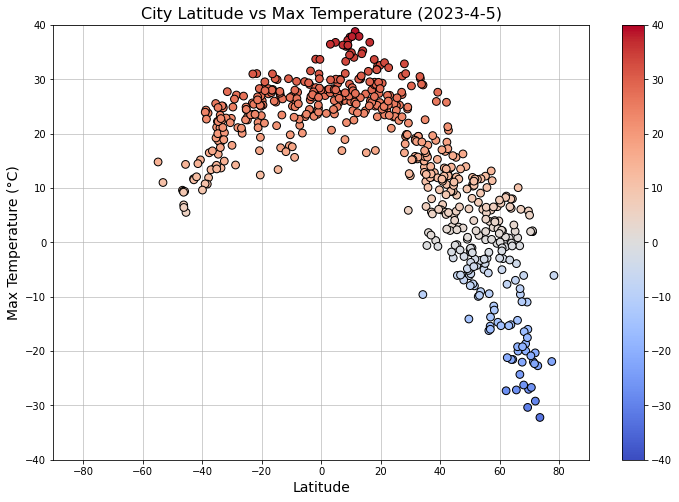

In [90]:
# Build scatter plot for latitude vs. temperature
fig, ax = plot_scatter(city_data_df["Lat"], city_data_df["Max Temp"],
                       "coolwarm", -40, 40,
                       "Latitude", "Max Temperature (°C)", "City Latitude vs Max Temperature (2023-4-5)",
                       (-90, 90), (-40, 40))

# plt.savefig("output_data/WeatherPy_Lat_v_Temp.png")
plt.show()

#### Latitude Vs. Humidity

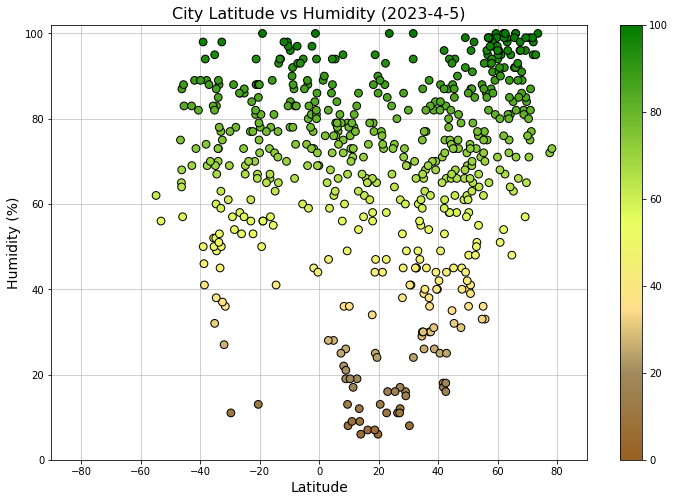

In [91]:
# Build the scatter plots for latitude vs. humidity
fig, ax = plot_scatter(city_data_df["Lat"], city_data_df["Humidity"],
                       humidity_cmap, 0, 100,
                       "Latitude", "Humidity (%)", "City Latitude vs Humidity (2023-4-5)",
                       (-90, 90), (0, 102))

# plt.savefig("output_data/WeatherPy_Lat_v_Humidity.png")
plt.show()

#### Latitude Vs. Cloudiness

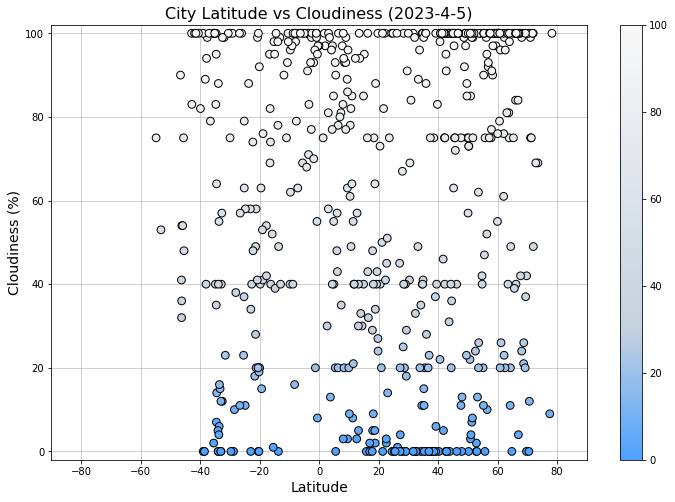

In [95]:
# Build the scatter plots for latitude vs. cloudiness
fig, ax = plot_scatter(city_data_df["Lat"], city_data_df["Cloudiness"],
                       cloudiness_cmap, 0, 100,
                       "Latitude", "Cloudiness (%)", "City Latitude vs Cloudiness (2023-4-5)",
                       (-90, 90), (-2, 102))

# plt.savefig("output_data/WeatherPy_Lat_v_Cloudiness.png")
plt.show()

#### Latitude vs. Wind Speed Plot

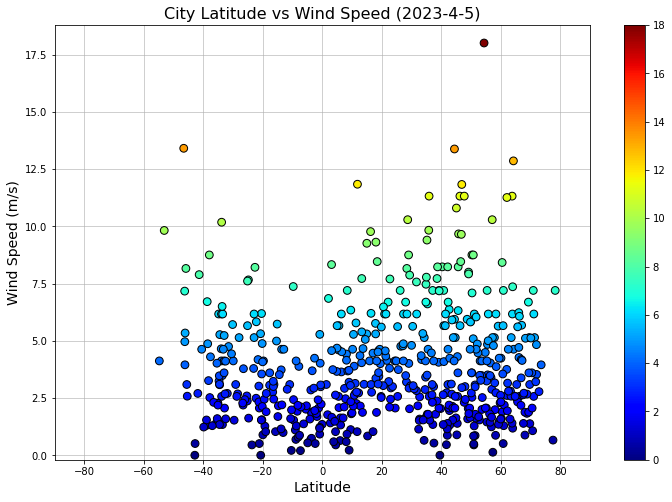

In [97]:
# Build the scatter plots for latitude vs. wind speed
fig, ax = plot_scatter(city_data_df["Lat"], city_data_df["Wind Speed"],
                       "jet", 0, 18,
                       "Latitude", "Wind Speed (m/s)", "City Latitude vs Wind Speed (2023-4-5)",
                       (-90, 90), (-0.2, 18.8))

# plt.savefig("output_data/WeatherPy_Lat_v_Wind.png")
plt.show()

---

## Requirement 2: Compute Linear Regression for Each Relationship


In [12]:
# Define a function to create Linear Regression plots
# YOUR CODE HERE

In [13]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)
# YOUR CODE HERE

# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,faya,18.3851,42.4509,22.06,35,21,2.60,SA,1666108228
1,farsund,58.0948,6.8047,13.30,100,0,7.65,NO,1666108228
3,jamestown,42.0970,-79.2353,5.77,77,100,9.77,US,1666107934
4,lanzhou,36.0564,103.7922,14.53,48,59,1.20,CN,1666108230
6,albany,42.6001,-73.9662,10.36,74,29,2.10,US,1666108231


In [14]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
# YOUR CODE HERE

# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
2,new norfolk,-42.7826,147.0587,11.72,58,12,1.34,AU,1666108230
5,ushuaia,-54.8000,-68.3000,8.81,81,75,3.09,AR,1666108231
7,carnarvon,-24.8667,113.6333,20.02,76,0,7.46,AU,1666108232
9,saint-pierre,-21.3393,55.4781,22.82,68,0,5.14,RE,1666108236
10,colorado,-22.8375,-51.9731,20.36,86,96,4.69,BR,1666107965


###  Temperature vs. Latitude Linear Regression Plot

The r-value is: 0.7161472181434118


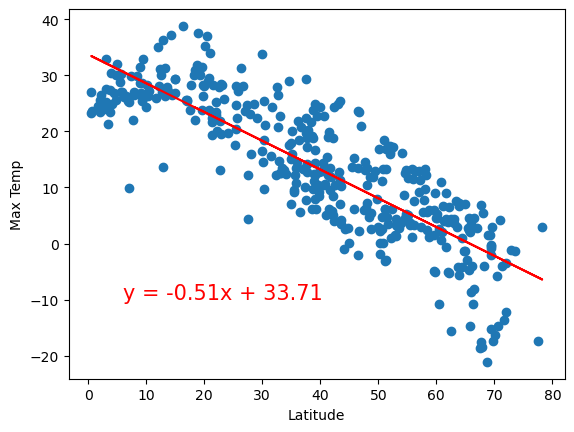

In [15]:
# Linear regression on Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.4121057168607245


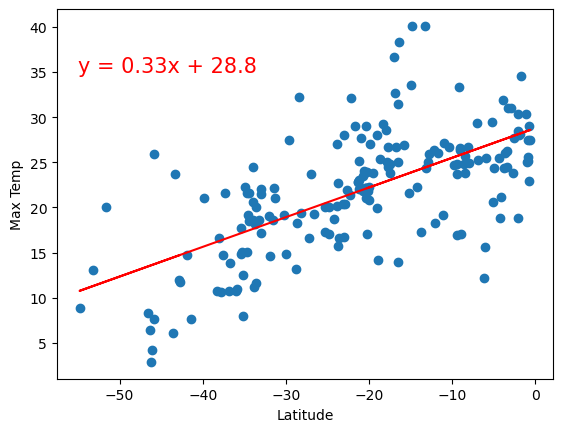

In [16]:
# Linear regression on Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Humidity vs. Latitude Linear Regression Plot

The r-value is: 0.05689741545789598


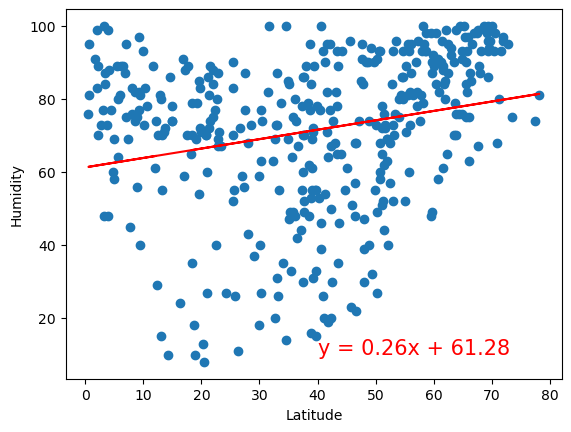

In [17]:
# Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.0002808747046324607


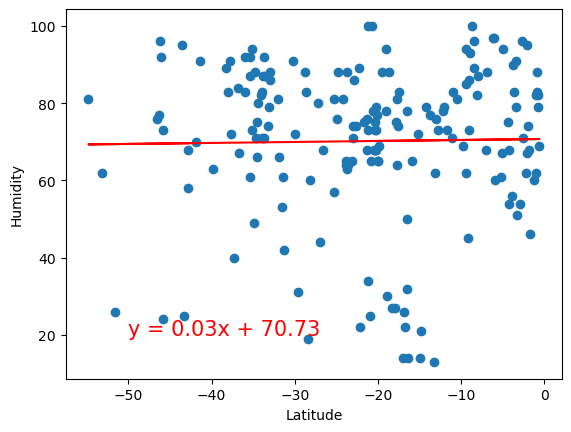

In [18]:
# Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Cloudiness vs. Latitude Linear Regression Plot

The r-value is: 0.024026517125811015


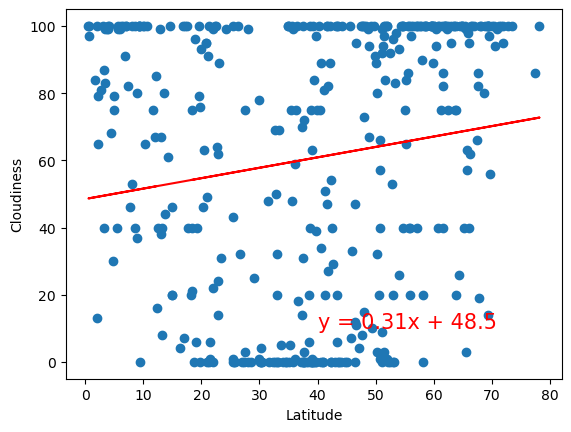

In [19]:
# Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.02056735429994368


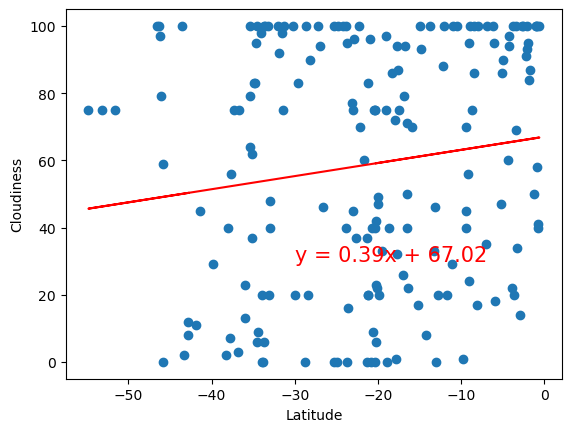

In [20]:
# Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Wind Speed vs. Latitude Linear Regression Plot

The r-value is: 0.030396762354449467


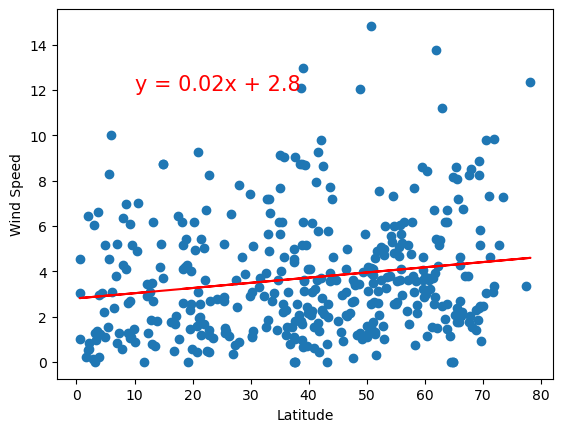

In [21]:
# Northern Hemisphere
# YOUR CODE HERE

The r-value is: 0.062239040700515696


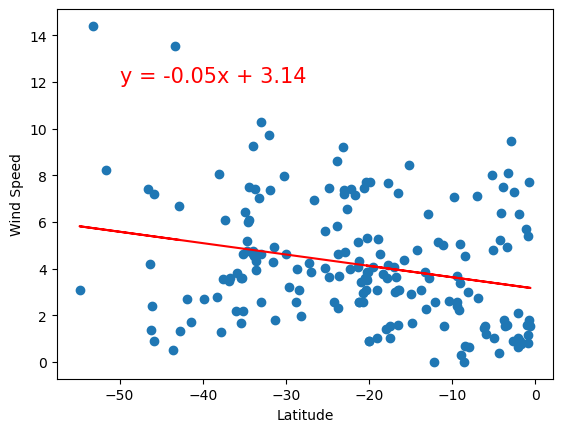

In [22]:
# Southern Hemisphere
# YOUR CODE HERE

**Discussion about the linear relationship:** YOUR RESPONSE HERE